# Linear Regression
in this notebook we run linear regression for a couple of experiments
* analysis of data
* prediction of data using the plain linear regression
* prediction of data using modified versions

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.base import BaseEstimator
from sklearn.preprocessing import PolynomialFeatures

## The Dataset

In [3]:
raw_data=pd.read_csv("wages.csv")
print(raw_data.shape)

(1000, 11)


In [4]:
raw_data.head()

,jobTitle,gender,age,perfEval,edu,dept,seniority,basePay,bonus,random,totalPay
0,Graphic Designer,Female,18,5,College,Operations,2,17831.923077,7644.615385,0,25476.538462
1,Software Engineer,Male,21,5,College,Management,5,44254.327359,8560.000000,0,52814.327359
2,Warehouse Associate,Female,19,3,PhD,Administration,5,35526.153846,3564.615385,1,39090.769231
3,Software Engineer,Male,20,5,Masters,Sales,4,41374.145446,7810.769231,0,49184.914677
4,Graphic Designer,Male,26,5,Masters,Engineering,5,41274.488125,7168.461538,0,48442.949663


In [5]:
target=raw_data.totalPay
raw_features =raw_data.drop(["basePay", "totalPay", "jobTitle", "bonus", "random"], axis=1)
features=pd.get_dummies(raw_features, drop_first=True)

In [6]:
features.head()

,age,perfEval,seniority,gender_Male,edu_High School,edu_Masters,edu_PhD,dept_Engineering,dept_Management,dept_Operations,dept_Sales
0,18,5,2,0,0,0,0,0,0,1,0
1,21,5,5,1,0,0,0,0,1,0,0
2,19,3,5,0,0,0,1,0,0,0,0
3,20,5,4,1,0,1,0,0,0,0,1
4,26,5,5,1,0,1,0,1,0,0,0


## Descriptive Data Analysis

### Checking for Correlation

In [7]:
print("age:", pearsonr(target, features.age)) # returns correlation and p-value (smaller means more indication of a non-coincidental result)
print("perfEval:", pearsonr(target, features.perfEval))
print("seniority:", pearsonr(target, features.seniority))
print("gender_Male:", pearsonr(target, features.gender_Male))

age: (0.5864808196936204, 1.9120505464328286e-93)
perfEval: (0.08264237006109747, 0.008933562826664302)
seniority: (0.4431618631334328, 2.3491352656765678e-49)
gender_Male: (0.1894087180884588, 1.5713743852868366e-09)


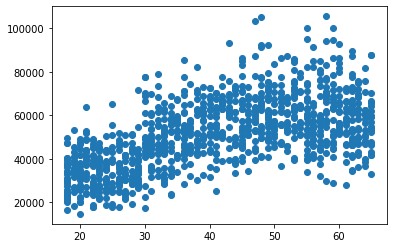

In [8]:
plt.scatter(raw_data.age, target)

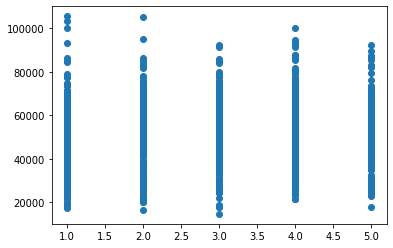

In [9]:
plt.scatter(raw_data.perfEval, target)

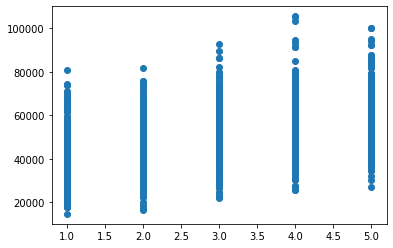

In [10]:
plt.scatter(raw_data.seniority, target)

Plots are nice, but often deceptive. Even though the two above plots look similar, the correlation they are supposed to show is absolutely not similar!

### Analysis By Linear Regression on the Full Dataset

In [11]:
reg_full= LinearRegression()
reg_full.fit(np.array(features), target)

LinearRegression()

In [12]:
r2_score(target, reg_full.predict(np.array(features)))

0.6332995687605143

There is still some unexplained variance in the data.

In [13]:
w=reg_full.coef_
w

array([  693.40899889,   959.39111084,  5314.11734147,  6351.90818824,
       -1686.68908512,  2121.40247172,  2663.03679388,  4016.97433706,
        4760.02439806,   -56.17017371,  1960.35274979])

In [14]:
for i in range(0, len(features.columns)): 
    print(features.columns[i], w[i])

age 693.4089988909451
perfEval 959.391110841008
seniority 5314.117341467803
gender_Male 6351.90818824222
edu_High School -1686.689085118144
edu_Masters 2121.40247171905
edu_PhD 2663.036793883483
dept_Engineering 4016.9743370641154
dept_Management 4760.0243980649575
dept_Operations -56.17017371365371
dept_Sales 1960.3527497910973


Interpretation Examples of the model: Ceteris Paribus
* aging a year correlates with a total pay increase of 693 dollars
* with high school as highest education (instead of college) decreases total pay by -1687 dollars, wheras a PhD increases the total py by 2663 dollars
* departments Engineering and Management lead to higher sallaries than Operations and Sales
* males receive 6352 dollars more than females

These assumptions are only correct under the assumption that the learned model fully describes the data!

The population parameters are NO measure for correlation (compare e.g. age and perfEval!)

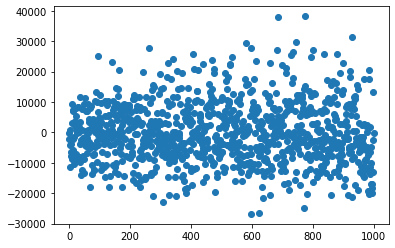

In [16]:
plt.scatter(range(0, len(target)), target-reg_full.predict(np.array(features)))
plt.savefig('residuals.pdf')

The residuals plot reveals high residuals, but no particular (non-random) behavior.

### Using Linear Regression to Investigate Specific Variables

In [17]:
reg_age = LinearRegression()
reg_age.fit(np.expand_dims(np.array(raw_data.age), axis=1), target)
w=reg_age.coef_
b=reg_age.intercept_
age_space=np.arange(0,70,1)
y=reg_age.predict(age_space.reshape(-1,1))

In [18]:
r2_score(target, reg_age.predict(np.array(raw_data[["age"]])))

0.3439597518685017

There is (of cause) much more unexplained variance.

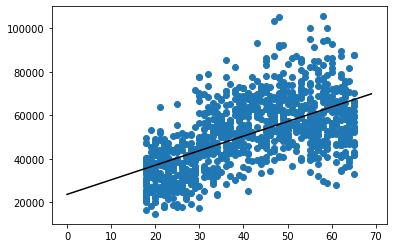

In [19]:
plt.scatter(raw_data.age, target)
plt.plot(age_space, y, c='black')

### Investigate Two Variables
Equal-Slopes method (assumption: both features are independent)

In [20]:
reg_age_sen = LinearRegression()
reg_age_sen.fit(np.array(raw_data[["age", "seniority"]]), target)

LinearRegression()

In [21]:
r2_score(target, reg_age_sen.predict(np.array(raw_data[["age", "seniority"]])))

0.551736382442495

In [22]:
age_space=np.arange(0,70,1)
seniority_space=np.arange(1,6,1)

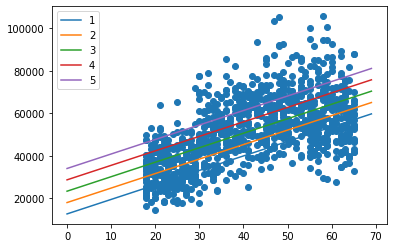

In [23]:
plt.scatter(raw_data.age, raw_data.totalPay)
for s in range(0,len(seniority_space), 1):
    grid=np.stack((age_space, seniority_space[s]*np.ones_like(age_space)), axis=1)
    y=reg_age_sen.predict(grid)
    plt.plot(age_space, y, label=seniority_space[s])
plt.legend()

higher age and higher seniority correlate positively with higher total pay
Linear model -> parallel slopes. Alterantive: Compute own models for each seniority level (treat different seniorities as different populations)

# Evaluation of Machine Learning Models

In [24]:
inner_cv = KFold(n_splits=10, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)


def evaluate_classifier(model):
    res = cross_val_score(model, X, y, cv=outer_cv, n_jobs=5, scoring='neg_mean_squared_error')
    print(f"The mean accuracy of the outer cross validation: "
      f"{res.mean():.3f} +/- {res.std():.3f}") 

def print_eval(result):
    #print(result, 3)
    print("{:,.2f}".format(np.round(res.mean(), 3)), "±", "{:,.2f}".format(np.round(res.std(), 3)))

## Linear Regression

In [25]:
res=cross_val_score(LinearRegression(), np.array(features), target, cv=outer_cv, n_jobs=5, scoring='neg_mean_squared_error')
print_eval(res)

-99,700,681.39 ± 16,051,977.04


## Polynomial Regression

In [26]:
poly=PolynomialFeatures(degree=4)
X_poly=poly.fit_transform(np.array(features))
print(features.shape)
print(X_poly.shape)
reg=LinearRegression()
reg.fit(X_poly,target)


(1000, 11)
(1000, 1365)


LinearRegression()

In [27]:
r2_score(target, reg.predict(X_poly))

0.8446086966291131

The significantly(!) more complex model explains the variance better. But, does it overfit? -> Proper ML Evaluation

In [28]:
class PolynomialRegression(BaseEstimator):
    def __init__(self, degree=1):
        self.degree = degree
    
    def fit(self, X, y, degree=None):
        self.model = LinearRegression(fit_intercept=False) # polynomial features create a feature with degree 0: 1
        self.poly_feature=PolynomialFeatures(degree=self.degree)
        X_poly=self.poly_feature.fit_transform(X)
        self.model.fit(X_poly, y)
    
    def predict(self, X):
        return self.model.predict(self.poly_feature.transform(X))
    
    def coef_(self):
        return self.model.coef_


In [29]:
poly_reg=PolynomialRegression()

poly_reg_grid={
    'degree':[1,2,3,4]
}
poly_reg_grid_cv = GridSearchCV(
    estimator=poly_reg, param_grid=poly_reg_grid, cv=inner_cv, n_jobs=5, scoring='neg_mean_squared_error')
res=cross_val_score(poly_reg_grid_cv, np.array(features), target, cv=outer_cv, n_jobs=5, scoring='neg_mean_squared_error')

print_eval(res)

-80,676,098.19 ± 10,825,993.27


In [30]:
poly_reg_grid_cv.fit(features,target)
poly_reg_grid_cv.best_params_

{'degree': 2}

Interpretation of polynomial regression is much more difficult. However, additional non-linear variable allow a better fit to the data.